# <b>背景</b>

<p>ET（essential tremor）患者：原发性震颤(Essential tremor)患者，特发性震颤（essential tremor，ＥＴ）最常见的运动障碍性疾病，主要为手、头部及身体其他部位的姿位性和运动性震颤。发病部位：上肢、头、面部、下颚。</p>
<p>参见文献： louis2003 Factors associated with increased risk of head tremor in essential tremor_ a community-based study in northern Manhattan）。</p>
<p>中线震颤（midline tremor）：   包含：面部（下颌部+唇部）、舌头、声音、头部（又称颈部）和躯干。<p>

    
# <b>目的</b>
1.1.	探索ET患者伴中线震颤的危险因素。
    
1.2.	ET患者伴焦虑和抑郁的危险因素    
    
# <b>任务</b>

探索ET患者伴中线震颤的危险因素：统计推断（独立性检验）面部（下颌部+唇部）、舌头、声音、头部（又称颈部）、躯干，以及焦虑和抑郁 等的关系（合并、伴发情况）


# <b>第一步 引包</b>

In [19]:
#引包：引入所需python包
import xlrd
import os
import re
import pandas as pd
import numpy as np
import itertools
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
from scipy.stats import mannwhitneyu
from sklearn.metrics import roc_curve,auc
import matplotlib as mpl
from matplotlib import pyplot as plt
from numpy import nan
from sklearn import linear_model, datasets
from sklearn.model_selection import train_test_split
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# <b>第二步 读取清洗后数据</b>

1）设置默认目录

2）读取csv文件；


In [20]:
dir = "./"
print(os.listdir(dir))

['.ipynb_checkpoints', '1.数据读取和清洗.ipynb', 'data', 'output', '2.中线震颤并发情况.ipynb', '3.人口特征统计.ipynb', '4.疾病特征统计.ipynb', '5.变量相关性和重要性.ipynb', '6.危险因子（逻辑回归）.ipynb', 'requirements.txt', 'pip_search_result.txt']


In [21]:
#清洗后数据
df = pd.read_csv(dir+"output/df_clean.csv",index_col=0) #第一列为行索引
#df = df.drop(columns = df.columns[0]) #删除不需要的列
df.head(2)

,编号,性别,工作状态合并栏,婚姻状况合并栏,年龄,发病年龄,主要受累部位=2,总病程,上肢病程,下肢病程,...,声音,颈部,面声颈部位分级分数,面声颈量表分数,面声颈有无,声颈量表部位分级,声颈量表分数,声颈有无,下肢震颤,意向性震颤
0,G001,0,1,1,72,68,0,4.0,4.000,0.001,...,0,0,0,0,0,0,0,0,1,0
1,G002,0,1,1,45,40,1,5.0,0.001,0.001,...,1,1,2,3,1,2,3,1,1,0


In [22]:
#中线震颤数据
midline1 = pd.read_csv(dir+"output/midline1.csv",index_col=0) #第一列为行索引
#midline1 = midline1.drop(columns = midline1.columns[0]) #删除不需要的列
midline1.head(2)

,编号,静止性上肢震颤分数,运动性上肢震颤总分,运动性下肢震颤分数,运动性四肢震颤总分,上肢静止性震颤,下肢静止性震颤,四肢静止性震颤,意向性震颤,面部,...,下肢震颤,抑郁分类,焦虑分类,运动性上肢震颤总分有无,运动性下肢震颤分数有无,运动性四肢震颤总分有无,面声颈部位分级分数有无,面声颈量表分数有无,声颈量表部位分级有无,声颈量表分数有无
0,G001,0,21,6,27,0,0,0,0,0,...,1,0,0,1,1,1,0,0,0,0
1,G002,0,13,2,15,0,0,0,0,0,...,1,0,0,1,1,1,1,1,1,1


# <b>第三步 准备数据 </b>
根据数据分析任务，处理数据

<b> 1) 筛选数据 </b>

筛选与疾病有关字段

In [23]:
inf = df.filter(items=["编号", '主观认知功能下降', 'MMSE',
       '家族史', '高血压', '糖尿病', '其他', '抗ET药物使用', '抗焦虑抑郁药物使用', '吸烟', '饮酒', 
        'TRS C:15-22',  '自述焦虑时长','HAMA总', '自述抑郁时长', 'HAMD总分', '抑郁分类', '3级', '匹兹堡总分','焦虑分类', 'HAMA3级'])  #,'面声颈部位分级分数','声颈量表部位分级'
inf.rename(columns = {"TRS C:15-22":"TRS_C","3级":"HAMD分级3级",'抑郁分类':'HAMD分级2级',"焦虑分类":"HAMA分级2级"},inplace = True)
inf = pd.merge(inf,midline1,on=["编号"] ,how = "left")
inf.head(2)

,编号,主观认知功能下降,MMSE,家族史,高血压,糖尿病,其他,抗ET药物使用,抗焦虑抑郁药物使用,吸烟,...,下肢震颤,抑郁分类,焦虑分类,运动性上肢震颤总分有无,运动性下肢震颤分数有无,运动性四肢震颤总分有无,面声颈部位分级分数有无,面声颈量表分数有无,声颈量表部位分级有无,声颈量表分数有无
0,G001,记忆力稍下降,27,0,0,0,0,0,0,0,...,1,0,0,1,1,1,0,0,0,0
1,G002,轻微下降,29,0,0,0,0,0,0,0,...,1,0,0,1,1,1,1,1,1,1


<b> 2) 一般变量转换成分类变量 </b>


In [24]:
for i in ["主观认知功能下降","高血压","糖尿病","其他","抗ET药物使用","抗焦虑抑郁药物使用","吸烟","饮酒","自述焦虑时长","自述抑郁时长"]:  #,"HAMD分级3级",'HAMD分级2级', "HAMA分级2级"]:
    print (i)
    inf[i] = np.where(inf[i].str.contains(r"\D"),1,0)
    inf[i] = inf[i].astype(float)
inf.head(2)

主观认知功能下降
高血压
糖尿病
其他
抗ET药物使用
抗焦虑抑郁药物使用
吸烟
饮酒
自述焦虑时长
自述抑郁时长


,编号,主观认知功能下降,MMSE,家族史,高血压,糖尿病,其他,抗ET药物使用,抗焦虑抑郁药物使用,吸烟,...,下肢震颤,抑郁分类,焦虑分类,运动性上肢震颤总分有无,运动性下肢震颤分数有无,运动性四肢震颤总分有无,面声颈部位分级分数有无,面声颈量表分数有无,声颈量表部位分级有无,声颈量表分数有无
0,G001,1.0,27,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,1,1,0,0,0,0
1,G002,1.0,29,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,1,1,1,1,1,1,1


<b>3）查看缺失值 </b>
查看后，没有缺失值

In [25]:
print ("   总记录数 ： " , inf.shape[0])
for i in ["主观认知功能下降","家族史","高血压","糖尿病","其他","抗ET药物使用","抗焦虑抑郁药物使用","吸烟","饮酒","自述焦虑时长","HAMD分级2级","HAMD分级3级"]:
    print (i)
    print (len(inf[i]))

   总记录数 ：  200
主观认知功能下降
200
家族史
200
高血压
200
糖尿病
200
其他
200
抗ET药物使用
200
抗焦虑抑郁药物使用
200
吸烟
200
饮酒
200
自述焦虑时长
200
HAMD分级2级
200
HAMD分级3级
200



# <b> 第四步 统计描述和统计推断 </b>

将统计描述和统计同时进行计算。

<b>独立性检验： </b>

H0：两变量相互不独立；H1：两变量相互独立

In [26]:
tremors = ['上肢静止性震颤', '下肢静止性震颤', '四肢静止性震颤','运动性上肢震颤总分有无', '运动性下肢震颤分数有无', '运动性四肢震颤总分有无', '下肢震颤','面部', '声音', '颈部','声颈有无',  '面声颈有无', 
            '抑郁分类', '焦虑分类','意向性震颤' ]
stat_pop = pd.DataFrame()
stat_pop1 = pd.DataFrame()
result  =pd.DataFrame() 
for i in tremors:
    print (i)
    #stat_factore = pd.crosstab(inf[i],inf["主观认知功能下降","家族史","高血压","糖尿病","其他","抗ET药物使用","抗焦虑抑郁药物使用","吸烟","饮酒","自述焦虑时长","HAMD分级2级","HAMD分级3级"],margins = True) 
    stat_pop1 = pd.crosstab(inf[i],inf["主观认知功能下降"],margins = True)
    stat_1 = pd.crosstab(inf[i],inf["主观认知功能下降"],margins = True)
    g, p, t,k, = chi2_contingency(stat_1)   #chi2_contingency(data)   #第一个值为卡方值，第二个值为P值，第三个值为自由度，第四个为与原数据数组同维度的对应理论值
    line = [(i,"主观认知功能下降",g,p)]   #chisquare(data,axis =None )频数
            #print (line)
    result = result.append(line) #未做“工作状态”的检验，因频数太小，不满足
    
    for j in ["家族史","高血压","糖尿病","其他","抗ET药物使用","抗焦虑抑郁药物使用","吸烟","饮酒","自述焦虑时长","HAMD分级2级","HAMD分级3级", 'HAMA分级2级', 'HAMA3级']:
            stat_1 = pd.crosstab(inf[i],inf[j],margins = True)             
            stat_pop1 = stat_pop1.join(stat_1,lsuffix = "" ,rsuffix=j)   
            
            g, p, t,k, = chi2_contingency(stat_1)   #chi2_contingency(data)   #第一个值为卡方值，第二个值为P值，第三个值为自由度，第四个为与原数据数组同维度的对应理论值
            line = [(i,j,g,p)]   #chisquare(data,axis =None )频数
            #print (line)
            result = result.append(line) #未做“工作状态”的检验，因频数太小，不满足
    
            
    list1 = ["MMSE","TRS_C","HAMA总","HAMD总分","匹兹堡总分"]
    for j in list1 :
        group1 = inf[inf[i] ==0][j]
        group1 = group1[~(group1.isna())]
        group2 = inf[inf[i] ==1][j] 
        group2 = group2[~(group2.isna())]
        g,p= stats.f_oneway(group1,group2)
        line = [(i,j,g,p)]
 
        result = result.append(line) 
 
    stat_continu = inf.pivot_table(index= i ,values=list1 , aggfunc =np.mean  )
    stat_pop1 = stat_pop1.join(stat_continu,lsuffix = "" ,rsuffix="_01")
    stat_pop1 = pd.DataFrame(stat_pop1)
    stat_pop1["症状"] = i
    stat_pop1["type"] = stat_pop1.index
    stat_pop = stat_pop.append(stat_pop1)
stat_pop["症状"] = stat_pop["症状"].apply(lambda x:x.replace("有无", ""))
stat_pop = stat_pop.loc[stat_pop["type"]!="All",:]
print ("------------------------统计结果-------------------")
print(stat_pop.head(2))

#stat_pop.to_csv(dir+"output/midline_stat_hos.csv")
result.columns = ["病症","因素","统计值","p值"] 
#result.to_csv(dir+"output/midline_testhos_pop.csv")
print ("------------------------检验结果-------------------")
print(result.head(2))

上肢静止性震颤
下肢静止性震颤
四肢静止性震颤
运动性上肢震颤总分有无
运动性下肢震颤分数有无
运动性四肢震颤总分有无
下肢震颤
面部
声音
颈部
声颈有无
面声颈有无
抑郁分类
焦虑分类
意向性震颤
------------------------统计结果-------------------
   0.0  1.0  All  0家族史  1家族史  All家族史  0.0  1.0  All高血压  0.0糖尿病  ...  1HAMA3级  \
0  120   59  179   102    77     179  160   19     179     172  ...       66   
1    5   16   21     8    13      21   18    3      21      20  ...        5   

   2HAMA3级  AllHAMA3级      HAMA总     HAMD总分       MMSE      TRS_C     匹兹堡总分  \
0       48        179  10.016760   9.234637  27.832402   6.564246  6.111732   
1        8         21  10.619048  11.809524  26.571429  11.476190  6.190476   

        症状  type  
0  上肢静止性震颤     0  
1  上肢静止性震颤     1  

[2 rows x 51 columns]
------------------------检验结果-------------------
        病症        因素        统计值        p值
0  上肢静止性震颤  主观认知功能下降  14.986255  0.004730
0  上肢静止性震颤       家族史   2.709188  0.607608


# <b>第五步 可视化：热力图 </b>
对统计检验结果，可视化展示有利于了解整体分布情况

颜色越深：p值越大，接受原假设，两变量独立，即该不是影响因子

颜色越浅：p值越小，不能接受原假设，两变量不独立，即是影响因子

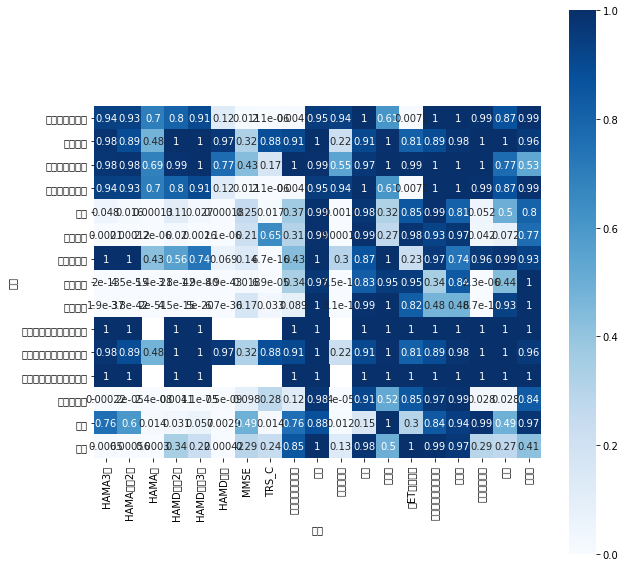

In [27]:
pvalue = result.pivot(index="病症",columns = '因素' , values ='p值')  #交叉表适合排列

plt.subplots(figsize=(10, 10)) # 设置画面大小
sns.heatmap(pvalue, annot=True, vmax=1, square=True, cmap="Blues")
plt.show()